<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/Demo_Keras_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short introduction to the Outlier package

In [1]:
# First step, install the package locally
!pip install --quiet git+https://github.com/liuxx479/Outlier.git

In [2]:
# Second step, import the dataset
%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Third step, profit...
dataset = tfds.load(name="gaussian_convergence", split="train")

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/gaussian_convergence/0.1.0.incomplete0X1HUA/gaussian_convergence-train.tfrecord



Dataset gaussian_convergence downloaded and prepared to /root/tensorflow_datasets/gaussian_convergence/0.1.0. Subsequent calls will reuse this data.


tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


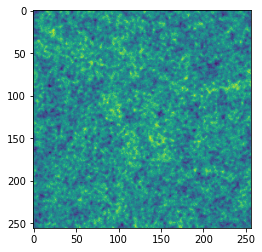

In [48]:
for example in dataset.take(1):  # Only take a single example
  kappa_map, params = example["map"], example["params"]
  imshow(kappa_map +0.01*randn(256,256))
  print(params)

In [0]:
import tensorflow as tf

## Implementing a simple resnet model
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y
  
def augmentation(x, y):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = x #+ 0.01*tf.random.normal(shape=(128,128,1))
  return x, y

In [0]:
DATASET_SIZE = 20000
BATCH_SIZE = 64

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = dataset.map(redefine).map(downsample)
# I've removed .map(augmentation) after repeat on the next line
train_dataset= full_dataset.take(train_size).repeat().shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).take(test_size).batch(BATCH_SIZE)

tf.Tensor([0.18652137 0.8056775 ], shape=(2,), dtype=float32)


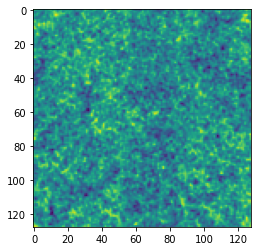

In [52]:
for example in train_dataset.take(1):  # Only take a single example
  kappa_map, params = example
  imshow(kappa_map[0,...,0])
  print(params[0])

tf.Tensor([0.3952816 0.9457618], shape=(2,), dtype=float32)


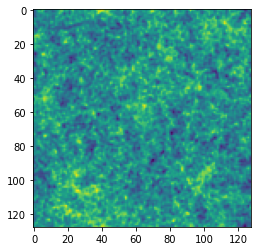

In [53]:
for example in test_dataset.take(1):  # Only take a single example
  kappa_map, params = example
  imshow(kappa_map[0,...,0])
  print(params[0])

### Let's define the neural network

In [0]:
inputs = tf.keras.Input(shape=(128, 128, 1))
resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                    weights=None,
                                                    input_shape=[128,128,1],
                                                    pooling='avg')
net = resnet(inputs)
outputs = tf.keras.layers.Dense(2)(net)

In [0]:
model = tf.keras.Model(inputs, outputs)

In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 2048)              23558528  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,562,626
Trainable params: 23,517,186
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse')   

In [65]:
history = model.fit(train_dataset, epochs=20, batch_size=BATCH_SIZE,
                    #validation_data=test_dataset, 
                    verbose=1, 
                    steps_per_epoch=int(0.8*20000/BATCH_SIZE)-1,
                    #validation_steps=2
                    )

Epoch 1/20
249/249 [==============================] - 110s 444ms/step - loss: 0.0063
Epoch 2/20
249/249 [==============================] - 109s 439ms/step - loss: 0.0061
Epoch 3/20
249/249 [==============================] - 109s 438ms/step - loss: 0.0058
Epoch 4/20
249/249 [==============================] - 109s 439ms/step - loss: 0.0056
Epoch 5/20
249/249 [==============================] - 109s 440ms/step - loss: 0.0053
Epoch 6/20
249/249 [==============================] - 110s 443ms/step - loss: 0.0052
Epoch 7/20
249/249 [==============================] - 109s 438ms/step - loss: 0.0049
Epoch 8/20
249/249 [==============================] - 110s 443ms/step - loss: 0.0047
Epoch 9/20
249/249 [==============================] - 111s 444ms/step - loss: 0.0048
Epoch 10/20
249/249 [==============================] - 110s 442ms/step - loss: 0.0047
Epoch 11/20
249/249 [==============================] - 110s 440ms/step - loss: 0.0044
Epoch 12/20
249/249 [==============================] - 111s 445

In [0]:
truth = next(train_dataset.as_numpy_iterator()) 

In [67]:
truth[0].shape

(64, 128, 128, 1)

In [68]:
truth[1].shape

(64, 2)

In [0]:
predictions = model.predict(x=truth[0])

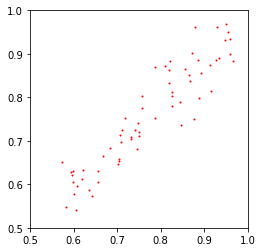

In [70]:
scatter(truth[1][:,1], predictions[:,1],color='r',s=1)
xlim(0.5,1)
ylim(0.5,1)
gca().set_aspect('equal')

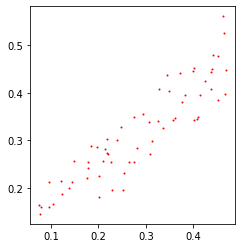

In [72]:
scatter(truth[1][:,0], predictions[:,0],color='r',s=1)
gca().set_aspect('equal')

In [0]:
# Now for test set
truth = next(test_dataset.as_numpy_iterator()) 

In [74]:
truth[0].shape

(64, 128, 128, 1)

In [0]:
predictions = model.predict(x=truth[0])

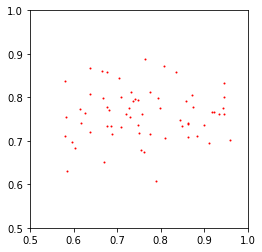

In [76]:
scatter(truth[1][:,1], predictions[:,1],color='r',s=1)
xlim(0.5,1)
ylim(0.5,1)
gca().set_aspect('equal')

(0.0, 0.5)

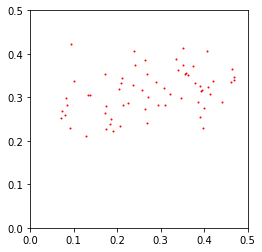

In [78]:
scatter(truth[1][:,0], predictions[:,0],color='r',s=1)
gca().set_aspect('equal')
xlim(0,0.5)
ylim(0,0.5)